### Using Different Regression Models to Predict ASO toxicity
**Goal:** The goal of this project is to identify more effective algorithms to predict antisense nucleotides (ASO) toxicity based on their sequence features. We will be training several linear regression models without regularization or with regularization (L1 and L2) to predict ASO toxicity based on the linear combination of their sequence features. We will used the new models to identify the features which most effectively enhance the accuracy of predicting whether a ASO is toxic or not.

**Data Problem:** The data task is to train and tune multiple linear regression models with or without regularization to predict the toxicity score of ASOs based on their sequence features.

**Expected Results:** The expected results would be several models using linear combination of some selected sequence features from an antisense oligonucleotide (ASO) to predict its toxicity. The prediction results are continuous and not binary, but we can choose different thresholds to define a toxic ASO versus a non-toxic ASO and convert the result to binary labels. Then we can use confusion matrix or receiver operation curve (ROC) to compare the performance of different models. In the original paper, a linear regression model is published for this purpose and my goal is to reproduce the authors’ key results by building a similar or even better models.  

**Data:**
The data is a from published literature by Roche in 2022.

Link: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9221153

This paper has a supplementary table which contains 1,800 antisense oligonucleotides sequences and their performance in a calcium assay. Measured calcium score can be used as a indicator for ASO toxicity. The ASOs with smaller calcium score are more toxic than these with greater calcium scores.

**Importance:**
My research question is important because big pharmaceutical companies like Roche, Biogen, Eli Lilly can spend >100 millions of dollars in developing genetic medicine (e.g. ASO) to treatment human disease. Currently, they rely on animal experiments and empirical evidence to determine the toxicity of an ASO. It is expensive and also time consuming. The capability to design a ASO without potential toxicity can streamline the whole drug development process and can create real values for these pharmaceutical companies. It is super important to figure out the sequence features within an ASO which can predict its toxcity.


In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn import set_config
from sklearn.metrics import mean_squared_error

warnings.simplefilter(action='ignore', category=FutureWarning)
set_config("display")

In [64]:
# load the data from a CSV file
df=pd.read_csv("C:\\Users\\zhk11\\Desktop\\Capstone project\\data and code\\Hagedorn_Suppl_TableS1_v2.csv")
# define the toxcic ASOs as the one that have measured calcium score smaller than 75
df.loc[df['Measured_CaO_score_cells'] <75,'tox_label'] ='yes'
df.loc[df['Measured_CaO_score_cells'] >= 75,'tox_label'] ='no'

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1825 entries, 0 to 1824
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Sequence                  1825 non-null   object 
 1   Set                       1825 non-null   object 
 2   MaxLength_A               1825 non-null   int64  
 3   MaxLength_T               1825 non-null   int64  
 4   MaxLength_G               1825 non-null   int64  
 5   MaxLength_C               1825 non-null   int64  
 6   Target                    1825 non-null   object 
 7   Length                    1825 non-null   int64  
 8   Number_LNA                1825 non-null   int64  
 9   Number_A                  1825 non-null   int64  
 10  Number_C                  1825 non-null   int64  
 11  Number_T                  1825 non-null   int64  
 12  Number_G                  1825 non-null   int64  
 13  Length_Gfree_5            1825 non-null   int64  
 14  Length_G

In [66]:
df.head()

,Sequence,Set,MaxLength_A,MaxLength_T,MaxLength_G,MaxLength_C,Target,Length,Number_LNA,Number_A,Number_C,Number_T,Number_G,Length_Gfree_5,Length_Gfree_3,Calculated_score,Measured_CaO_score_cells,tox_label
0,AAAtctataataaccacCAC,Control,3,1,0,2,None,20,6,10,6,4,0,20,20,82.36,80.17,no
1,CAAAtcatccatctatAAAC,Control,3,1,0,2,None,20,8,9,6,5,0,20,20,80.77,88.84,no
2,TACcatacaataactttAAC,Control,2,3,0,2,None,20,6,9,5,6,0,20,20,81.15,76.53,no
3,CTAAatccttaatatcAAAC,Control,3,2,0,2,None,20,8,9,5,6,0,20,20,81.15,79.26,no
4,CcAAAtcttataataACtAC,Control,3,2,0,2,None,20,8,9,5,6,0,20,20,81.15,80.17,no


In [67]:
df.describe()

,MaxLength_A,MaxLength_T,MaxLength_G,MaxLength_C,Length,Number_LNA,Number_A,Number_C,Number_T,Number_G,Length_Gfree_5,Length_Gfree_3,Calculated_score,Measured_CaO_score_cells
count,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000
mean,1.970411,2.412603,1.071233,2.024658,17.796164,6.273973,4.808767,4.991781,5.810959,2.184658,8.730411,8.897534,58.015047,61.351507
std,0.846303,1.089300,0.820094,0.793301,1.961831,1.142052,1.897057,1.767593,2.589598,2.221650,7.659752,7.680926,20.988695,38.893822
min,0.000000,0.000000,0.000000,0.000000,14.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-11.620000,0.000000
25%,1.000000,2.000000,0.000000,1.000000,16.000000,6.000000,4.000000,4.000000,4.000000,0.000000,2.000000,2.000000,42.460000,34.250000
50%,2.000000,2.000000,1.000000,2.000000,17.000000,6.000000,5.000000,5.000000,6.000000,1.000000,6.000000,6.000000,62.120000,62.110000
75%,3.000000,3.000000,2.000000,2.000000,20.000000,7.000000,6.000000,6.000000,7.000000,4.000000,20.000000,20.000000,75.320000,84.120000
max,5.000000,6.000000,3.000000,5.000000,25.000000,10.000000,11.000000,10.000000,15.000000,10.000000,20.000000,20.000000,99.930000,200.000000


### Data quality check and preprocessing
**Based on feedback from my instructor Jessica Cervi, I added several plots related to data qaulity check and preprocessing.** 

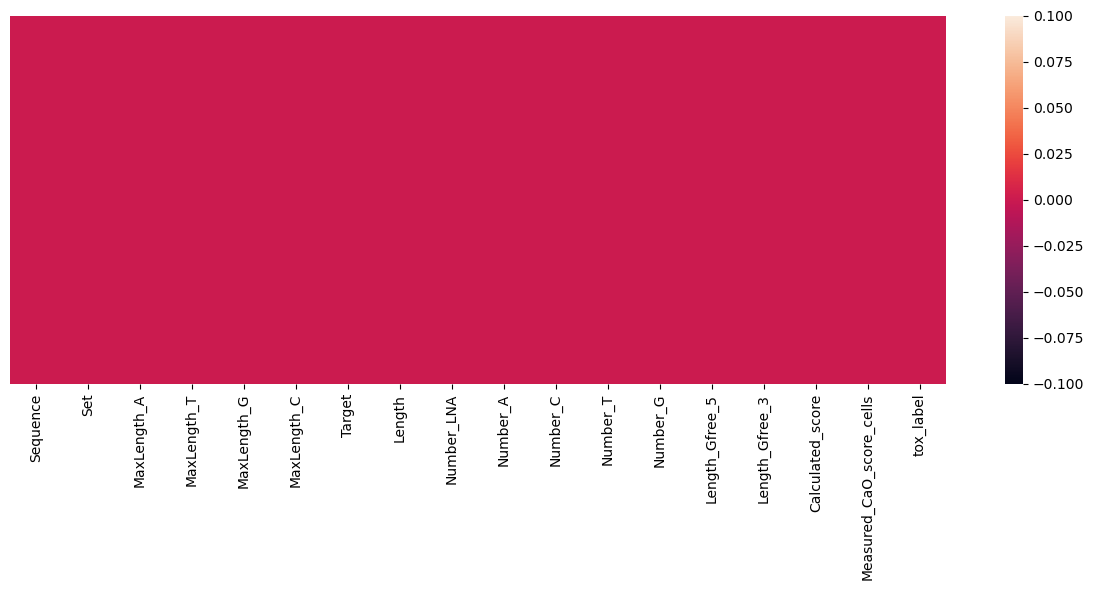

In [69]:
# Use a heatmap to check if any columns have null values
plt.figure(figsize=(12,6))
sns.heatmap(df.isna(),yticklabels=False)
plt.tight_layout()

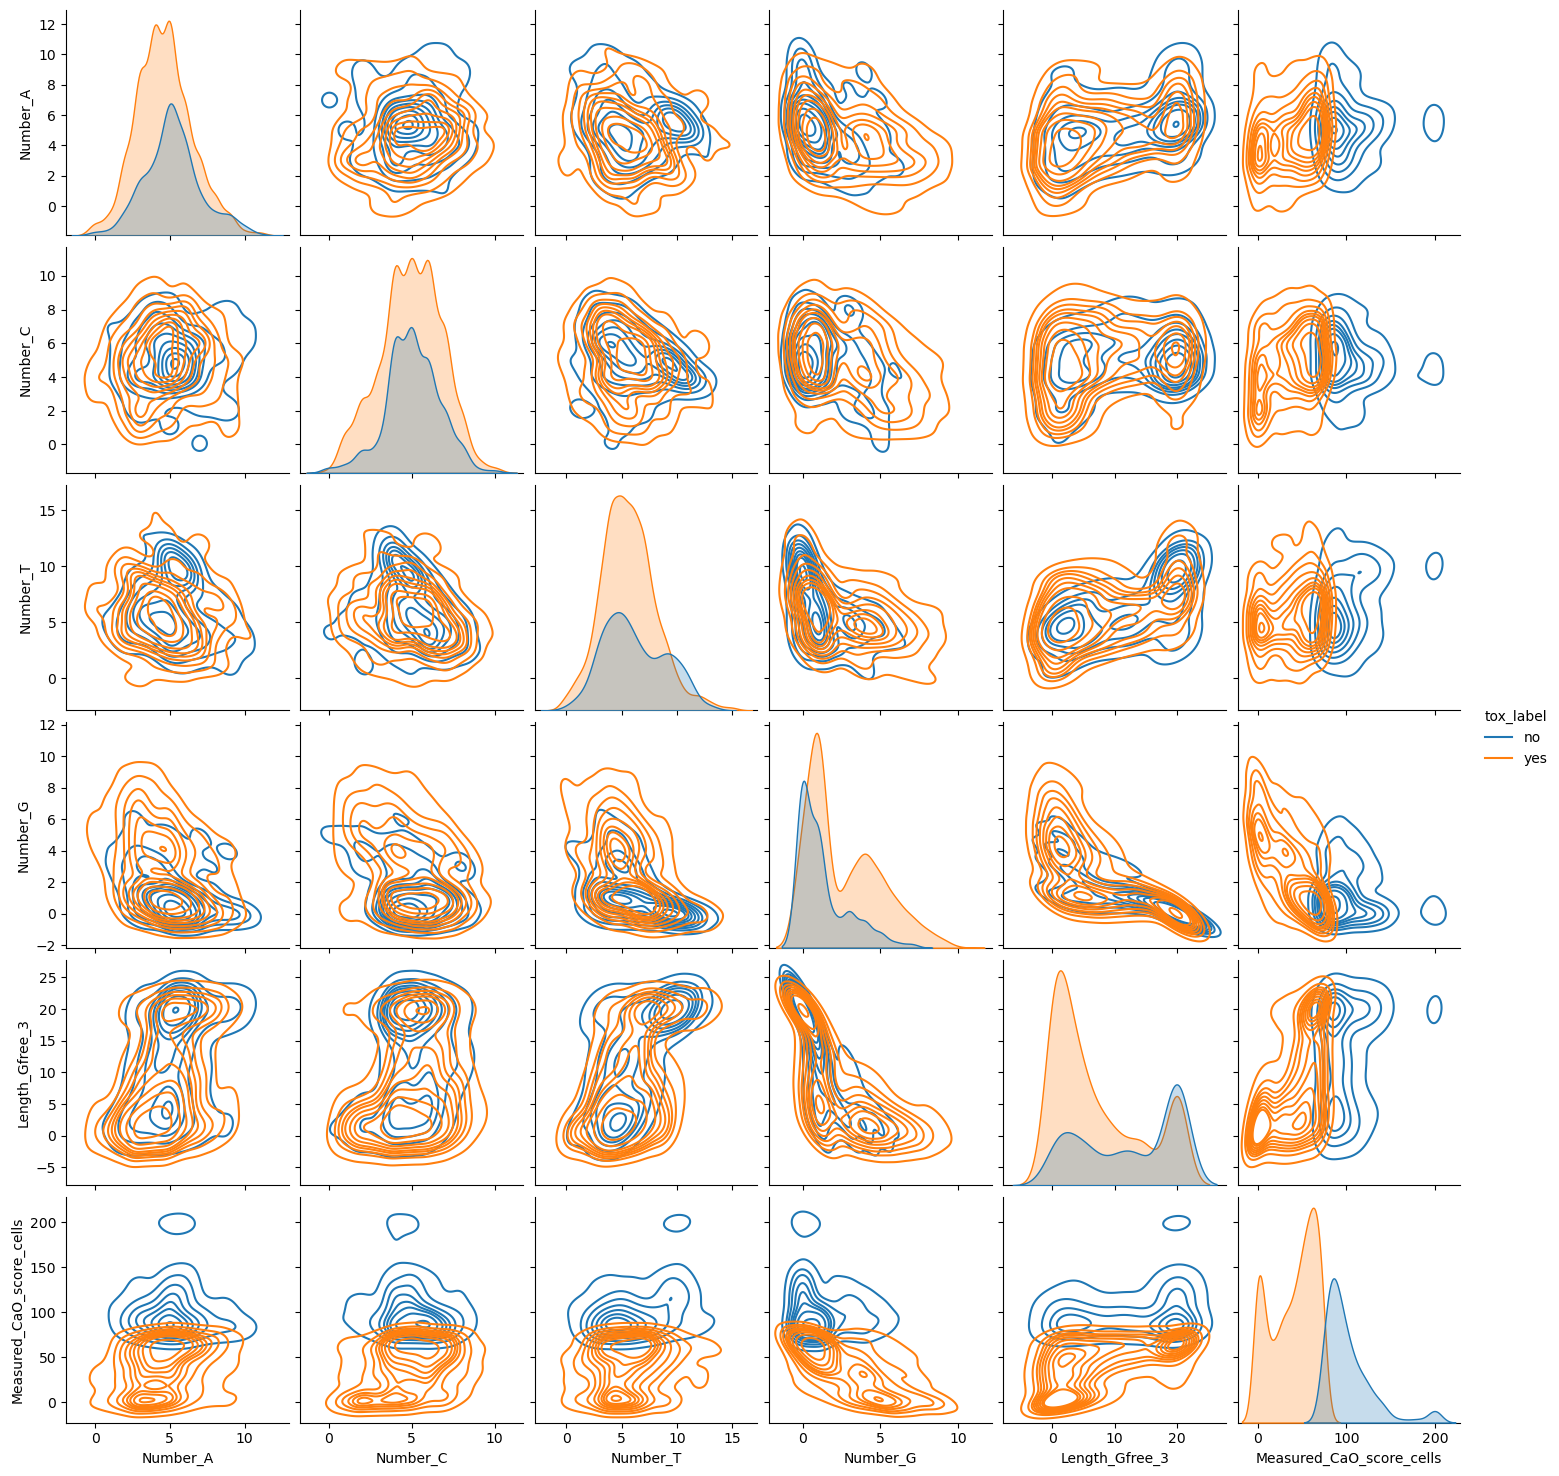

In [70]:
# chose a subset features used by the original Roche paper for pariplot
df_subset=df[['Number_A','Number_C','Number_T','Number_G','Length_Gfree_3','Measured_CaO_score_cells','tox_label']]
# use kde plot to increase data visibility
sns.pairplot(df_subset,hue='tox_label',kind="kde")
plt.show()

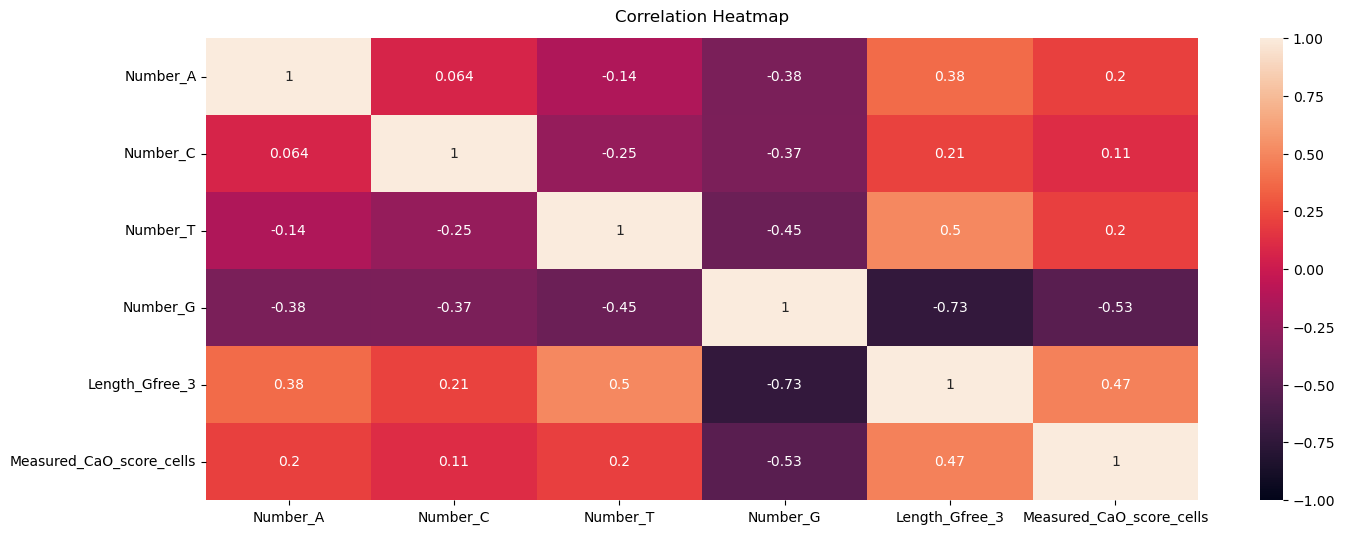

In [72]:
plt.figure(figsize=(16, 6))
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(df_subset.corr(), vmin=-1, vmax=1, annot=True)
# Give a title to the heatmap. 
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

### Data quality check and data preprocessing conclusions
1. All the columns have no null values.
2. The pairplot shows the two features ('Number_G' and 'length_Gfree_3') has distinct distribution between toxic and non-toxic ASOs.
3. The correlation heatmap shows that there is a negative correlation between 'Number_G' and 'length_Gfree_3'.
4. The correlation heatmap shows that there is a negative correlation between 'Number_G' and 'Measured_caO_score_cells'.

### Section 1: Using the same five features as published by Roche to predict ASO toxicity

In [73]:
# define the base model for ASO toxicity prediction based on Roche published results
def baseModel(x):
    return 136.0430-3.1263*x['Number_A']-5.1100*x['Number_C']-4.7217*x['Number_T']-10.1264*x['Number_G']+1.3577*x['Length_Gfree_3']

In [74]:
# calcium score is the target, which can reflect ASO toxicity; Smaller calcium score indicates one ASO is more toxic
y=df['Measured_CaO_score_cells']
X=df[['Number_A','Number_C','Number_T','Number_G','Length_Gfree_3']]

**Import training set and test set:** In the original paper, the author already divided the data into training set and test set and we don't have to split the data by ourselves. Training set and test set can be directly imported for analysis.

In [75]:
X_train=X.loc[df['Set']=='Training'];
y_train=y.loc[df['Set']=='Training'];
X_test=X.loc[df['Set']!='Training'];
y_test=y.loc[df['Set']!='Training'];

**Build a basic linear regression model without regularization** 

In [76]:
LR= LinearRegression().fit(X_train,y_train)
print(LR.coef_)
print(LR.intercept_)

[ -3.12631878  -5.1099949   -4.72166014 -10.12635343   1.35769713]
136.04297448149526


In [77]:
print(mean_squared_error(LR.predict(X_train),y_train))
print(mean_squared_error(LR.predict(X_test),y_test))

830.8701791969249
2716.378969878299


**Build a Ridge regression model with L2 regularization and use GridSearchCV to tune the hyperparameter alpha** 

In [78]:
ridge_param_dict = {'ridge__alpha': np.logspace(0, 3, 200)}
ridge_pipe = Pipeline([('ridge', Ridge())])
ridge_grid = GridSearchCV(ridge_pipe, param_grid=ridge_param_dict)
ridge_grid.fit(X_train, y_train)
ridge_train_preds = ridge_grid.predict(X_train)
ridge_test_preds = ridge_grid.predict(X_test)
ridge_train_mse = mean_squared_error(y_train, ridge_train_preds)
ridge_test_mse = mean_squared_error(y_test, ridge_test_preds)

print(f'Train MSE: {ridge_train_mse}')
print(f'Test MSE: {ridge_test_mse}')
print (f'best alpha:{ridge_grid.best_params_}')
ridge_pipe

Train MSE: 830.8702490797909
Test MSE: 2716.416554903375
best alpha:{'ridge__alpha': 1.0}


Pipeline(steps=[('ridge', Ridge())])

In [79]:
best_estimator_ridge = ridge_grid.best_estimator_
best_model_ridge = ridge_grid.best_estimator_.named_steps['ridge']
feature_names = X_train.columns
coefs_ridge = best_model_ridge.coef_
print(feature_names)
print(coefs_ridge)
print(best_model_ridge.intercept_)

Index(['Number_A', 'Number_C', 'Number_T', 'Number_G', 'Length_Gfree_3'], dtype='object')
[ -3.12265566  -5.1050084   -4.71768081 -10.12049777   1.35767714]
135.9645333196116


**Build a Lasso regression model with L1 regularization and use GridSearchCV to tune the hyperparameter alpha**

In [80]:
lasso_param_dict = {'lasso__alpha': np.logspace(-1.5, 2, 200)}
lasso_pipe = Pipeline([('lasso', Lasso())])
lasso_grid = GridSearchCV(lasso_pipe, param_grid=lasso_param_dict)
lasso_grid.fit(X_train, y_train)
lasso_train_preds = lasso_grid.predict(X_train)
lasso_test_preds = lasso_grid.predict(X_test)
lasso_train_mse = mean_squared_error(y_train, lasso_train_preds)
lasso_test_mse = mean_squared_error(y_test, lasso_test_preds)
### END SOLUTION

# ANSWER CHECK
print(f'Train MSE: {lasso_train_mse}')
print(f'Test MSE: {lasso_test_mse}')
print (f'best alpha:{lasso_grid.best_params_}')
lasso_pipe

Train MSE: 830.8750786403004
Test MSE: 2716.693941924275
best alpha:{'lasso__alpha': 0.03162277660168379}


Pipeline(steps=[('lasso', Lasso())])

In [81]:
best_estimator_lasso = lasso_grid.best_estimator_
best_model_lasso = lasso_grid.best_estimator_.named_steps['lasso']
feature_names = X_train.columns
coefs_lasso = best_model_lasso.coef_
print(feature_names)
print(coefs_lasso)
print(best_model_lasso.intercept_)

Index(['Number_A', 'Number_C', 'Number_T', 'Number_G', 'Length_Gfree_3'], dtype='object')
[ -3.08948712  -5.06692582  -4.68464915 -10.08592295   1.35397987]
135.37891250918256


In [82]:
# summarize the results of coefficients of all features from different models
res_dict = {'Model': ['Roche', 'Linear Regression','Ridge','Lasso'],
            'Number_A': [-3.1263, -3.1263, -3.1227, -3.0895],
            'Number_C': [-5.1100, -5.1100, -5.1050,-5.0669],
            'Number_T': [-4.7217, -4.7217, -4.7177,-4.6846],
            'Number_G': [-10.1264, -10.1264, -10.1205,-10.0859],
            'Length_Gfree_3': [1.3577, 1.3577, 1.3577,1.3540],
            'Intercept': [136.0430, 136.0430, 135.9645,135.3789],
           }
results_df = pd.DataFrame(res_dict).set_index('Model')
results_df

,Number_A,Number_C,Number_T,Number_G,Length_Gfree_3,Intercept
Model,,,,,,
Roche,-3.1263,-5.1100,-4.7217,-10.1264,1.3577,136.0430
Linear Regression,-3.1263,-5.1100,-4.7217,-10.1264,1.3577,136.0430
Ridge,-3.1227,-5.1050,-4.7177,-10.1205,1.3577,135.9645
Lasso,-3.0895,-5.0669,-4.6846,-10.0859,1.3540,135.3789


In [83]:
# summarize the training_MSE and test_MSE from different models
res_dict1 = {'Model': ['Roche', 'Linear Regression','Ridge','Lasso'],
            'Training_MSE': [830.87, 830.87,830.87,830.88],
            'Test_MSE': [2716.38, 2716.38, 2716.42,2716.69],
           }
results_df1 = pd.DataFrame(res_dict1).set_index('Model')
results_df1

,Training_MSE,Test_MSE
Model,,
Roche,830.87,2716.38
Linear Regression,830.87,2716.38
Ridge,830.87,2716.42
Lasso,830.88,2716.69


### Section 1 conclusions
1. Linear Regression model gave rise to identical results as the published Roche model for all the coefficients, traing_MSE, test_MSE, which can validate the procedure of my modeling process.
2. Using Ridge or Lasso Regression did not significantly change the coefficients, traing_MSE, test_MSE, compared to the model without regularization.
3. It seems like the test_MSE is signifcantly larger than training_MSE, that could be due to the fact that the training set data was not collected use the identical manner as the testing set and there might be some systematic shift between tranining set values and test set values. Therefore, in Section 2, I will use some tools I learned for classification (e.g. confusion matrix, ROC curve) to further evaluate the model.
4. **All the models suggest that the ASOs with more guanine (G) in its sequence tend be more toxic, because the feature Number_G has most negative coefficient, which is consistent with Roche published results.**

### Section 2: Using the classification tools to evaluate different regression models

In [84]:
df_test=df.loc[df['Set']!='Training']
df_test1=df_test.copy()
df_test1['lasso_predict_toxscore']=lasso_test_preds; 
df_test1['ridge_predict_toxscore']=ridge_test_preds;
df_test1['Base_predict_toxscore']=df_test['Calculated_score']

Text(0.5, 1.0, 'Toxcic ASO Counts in Test Set')

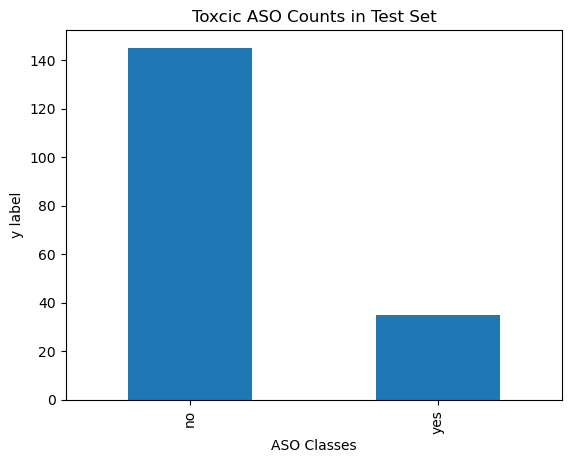

In [85]:
# check the distribution of toxic and non-toxic ASOs in test set
df_test['tox_label'].value_counts().plot(kind='bar')
plt.xlabel('ASO Classes')
plt.ylabel('y label')
plt.title('Toxcic ASO Counts in Test Set')

**calculate the sensitivity, specificity and accuracy of differnet models based on differnt threshold**

In [86]:
base_recall=[]; lasso_recall=[];ridge_recall=[];
base_specificity=[]; lasso_specificity=[]; ridge_specificity=[];
base_accuracy=[]; lasso_accuracy=[]; ridge_accuracy=[];

# create a for loop to store the sensitivity, specificity and accurary values based on different threshold values (i)
for i in np.arange(-10,120,0.5):
    df_test1.loc[df_test1['lasso_predict_toxscore']>i,['lasso_predict_toxLabel']]='no'
    df_test1.loc[df_test1['lasso_predict_toxscore']<=i,['lasso_predict_toxLabel']]='yes'
    df_test1.loc[df_test1['Base_predict_toxscore']>i,['Base_predict_toxLabel']]='no'
    df_test1.loc[df_test1['Base_predict_toxscore']<=i,['Base_predict_toxLabel']]='yes'
    df_test1.loc[df_test1['ridge_predict_toxscore']>i,['ridge_predict_toxLabel']]='no'
    df_test1.loc[df_test1['ridge_predict_toxscore']<=i,['ridge_predict_toxLabel']]='yes'

    base_recall.append(recall_score(df_test1['tox_label'],df_test1['Base_predict_toxLabel'],pos_label='yes'))
    lasso_recall.append(recall_score(df_test1['tox_label'],df_test1['lasso_predict_toxLabel'],pos_label='yes'))
    ridge_recall.append(recall_score(df_test1['tox_label'],df_test1['ridge_predict_toxLabel'],pos_label='yes'))
    
    base_accuracy.append(accuracy_score(df_test1['tox_label'],df_test1['Base_predict_toxLabel']))
    lasso_accuracy.append(accuracy_score(df_test1['tox_label'],df_test1['lasso_predict_toxLabel']))
    ridge_accuracy.append(accuracy_score(df_test1['tox_label'],df_test1['lasso_predict_toxLabel']))
    
    base_specificity.append(recall_score(df_test1['tox_label'],df_test1['Base_predict_toxLabel'],pos_label='no'))
    lasso_specificity.append(recall_score(df_test1['tox_label'],df_test1['lasso_predict_toxLabel'],pos_label='no'))
    ridge_specificity.append(recall_score(df_test1['tox_label'],df_test1['ridge_predict_toxLabel'],pos_label='no'))
    

In [87]:
# find the optimal threshold for differnet models when maximum accuracy is achieved
Threshold_range=np.arange(-10,120,0.5)
base_threshold=Threshold_range[base_accuracy.index(max(base_accuracy))]
lasso_threshold=Threshold_range[lasso_accuracy.index(max(lasso_accuracy))]
ridge_threshold=Threshold_range[ridge_accuracy.index(max(ridge_accuracy))]

Text(0.5, 1.0, 'Confusion Matrix for Roche Model')

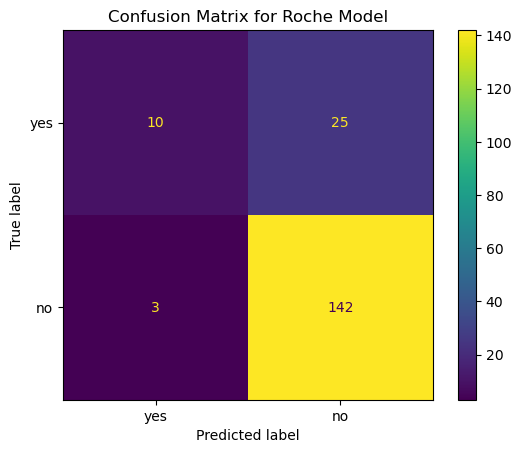

In [88]:
# plot the Confusion Matrix for Roche Model
df_test1.loc[df_test1['Base_predict_toxscore']>base_threshold,['Base_predict_toxLabel']]='no'
df_test1.loc[df_test1['Base_predict_toxscore']<=base_threshold,['Base_predict_toxLabel']]='yes'
confusion_mat = confusion_matrix(df_test1['tox_label'],df_test1['Base_predict_toxLabel'],  labels=['yes', 'no'])
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=['yes', 'no' ])
disp.plot()
plt.title ('Confusion Matrix for Roche Model')

Text(0.5, 1.0, 'Confusion Matrix for Lasso Regression Model')

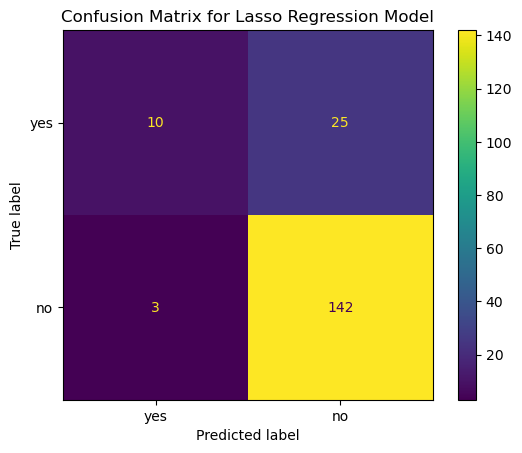

In [42]:
# plot the Confusion Matrix for Lasso Regression Model
df_test1.loc[df_test1['lasso_predict_toxscore']>lasso_threshold,['lasso_predict_toxLabel']]='no'
df_test1.loc[df_test1['lasso_predict_toxscore']<=lasso_threshold,['lasso_predict_toxLabel']]='yes'
confusion_mat = confusion_matrix(df_test1['tox_label'],df_test1['lasso_predict_toxLabel'],  labels=['yes', 'no'])
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=['yes', 'no' ])
disp.plot()
plt.title ('Confusion Matrix for Lasso Regression Model')

Text(0.5, 1.0, 'Confusion Matrix for Ridge Regression Model')

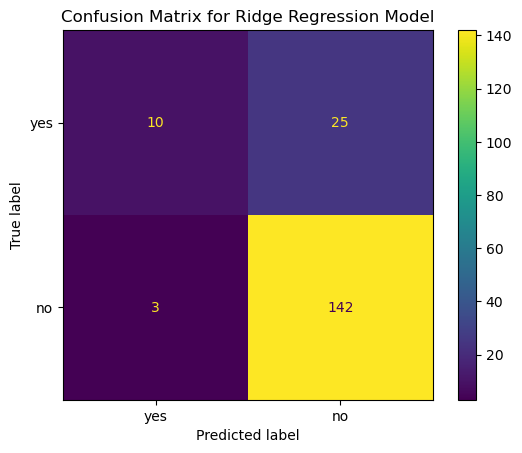

In [89]:
# plot the Confusion Matrix for Ridge Regression Model
df_test1.loc[df_test1['ridge_predict_toxscore']>ridge_threshold,['ridge_predict_toxLabel']]='no'
df_test1.loc[df_test1['ridge_predict_toxscore']<=ridge_threshold,['ridge_predict_toxLabel']]='yes'
confusion_mat = confusion_matrix(df_test1['tox_label'],df_test1['ridge_predict_toxLabel'],  labels=['yes', 'no'])
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=['yes', 'no' ])
disp.plot()
plt.title ('Confusion Matrix for Ridge Regression Model')

0.8212807881773401
0.8219704433497538
0.8215763546798031


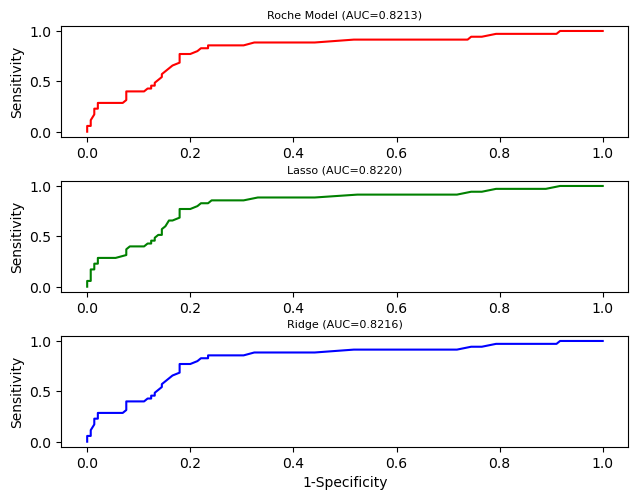

In [90]:
# use subplot to compare ROC curves in the same figure
a1 = [1-x for x in base_specificity]
a2=[1-x for x in lasso_specificity]
a3=[1-x for x in ridge_specificity]

fig, ax = plt.subplots(nrows=3, ncols=1)
fig.tight_layout()
ax[0].plot(a1, base_recall, c='red')
ax[1].plot(a2, lasso_recall, c='green')
ax[2].plot(a3, ridge_recall, c='blue')

ax[0].set(ylabel='Sensitivity')
ax[1].set(ylabel='Sensitivity')
ax[2].set(xlabel='1-Specificity',ylabel='Sensitivity')
ax[0].set_title('Roche Model (AUC=0.8213)',fontsize=8)
ax[1].set_title('Lasso (AUC=0.8220)',fontsize=8)
ax[2].set_title('Ridge (AUC=0.8216)',fontsize=8)


auc1=0 ; auc2=0; auc3=0
for k in range(len(a1)-3):
    auc1 += (a1[k+1] - a1[k]) * (base_recall[k+1] + base_recall[k]) / 2
for k in range(len(a2)-3):
    auc2 += (a2[k+1] - a2[k]) * (lasso_recall[k+1] + lasso_recall[k]) / 2
for k in range(len(a2)-3):
    auc3 += (a3[k+1] - a3[k]) * (ridge_recall[k+1] + ridge_recall[k]) / 2
print(auc1)
print(auc2)
print(auc3)


### Section 2 conclusions
**1. All the 3 models (Linear Regressio, Lasso Regression and Ridge Regression)  gave rise to very similar results in Confusion Matrix and ROC curve.**

**2. The AUC for all the 3 ROC curves is around 0.82, which suggests that they perform relatively well for the classification task to predict toxic vs. non-toxic ASOs**

### Section 3: Adding additional features to predict ASO toxicity

**In section 3, we will explore whether adding additional features beyond the original Roche model can further improve the performance of the model.**

In [91]:
# adding additional features to the model
X=df[['MaxLength_A','MaxLength_T','MaxLength_G','MaxLength_C','Number_A','Number_C','Number_T','Number_G','Length_Gfree_5','Length_Gfree_3']]
y=df['Measured_CaO_score_cells']

In [92]:
X_train_new=X.loc[df['Set']=='Training'];
y_train_new=y.loc[df['Set']=='Training'];
X_test_new=X.loc[df['Set']!='Training'];
y_test_new=y.loc[df['Set']!='Training'];

**Build a Linear Regression model without regularization and with additional features** 

In [93]:
LR_new= LinearRegression().fit(X_train_new,y_train_new)
print(LR_new.coef_)
print(LR_new.intercept_)

[ 6.01319303 -0.70669438 -4.3907814  -1.13672276 -4.75722225 -4.63214634
 -4.59492784 -8.6835193   0.0664958   1.18200154]
135.53131976765096


In [94]:
print(mean_squared_error(LR_new.predict(X_train_new),y_train_new))
print(mean_squared_error(LR_new.predict(X_test_new),y_test_new))

812.1132344441913
2610.425695680793


**Build a Lasso Regression model with L1 regularization and with additional features** 

In [96]:
lasso_param_dict = {'lasso__alpha': np.logspace(-1.5, 2, 200)}
lasso_pipe_new = Pipeline([('lasso', Lasso())])
lasso_grid_new = GridSearchCV(lasso_pipe_new, param_grid=lasso_param_dict)
lasso_grid_new.fit(X_train_new, y_train_new)
lasso_train_preds_new = lasso_grid_new.predict(X_train_new)
lasso_test_preds_new = lasso_grid_new.predict(X_test_new)
lasso_train_mse = mean_squared_error(y_train_new, lasso_train_preds_new)
lasso_test_mse = mean_squared_error(y_test_new, lasso_test_preds_new)
### END SOLUTION

# ANSWER CHECK
print(f'Train MSE: {lasso_train_mse}')
print(f'Test MSE: {lasso_test_mse}')
lasso_pipe_new

Train MSE: 812.128984994577
Test MSE: 2612.893587502172


Pipeline(steps=[('lasso', Lasso())])

In [97]:
best_estimator_lasso_new = lasso_grid_new.best_estimator_
best_model_lasso_new= lasso_grid_new.best_estimator_.named_steps['lasso']
feature_names = X_train_new.columns
coefs_lasso_new = best_model_lasso_new.coef_
print(feature_names)
print(coefs_lasso_new)
print(best_model_lasso_new.intercept_)

Index(['MaxLength_A', 'MaxLength_T', 'MaxLength_G', 'MaxLength_C', 'Number_A',
       'Number_C', 'Number_T', 'Number_G', 'Length_Gfree_5', 'Length_Gfree_3'],
      dtype='object')
[ 5.91790339 -0.67596593 -4.21699527 -1.06121127 -4.69282762 -4.60829061
 -4.56458577 -8.67590506  0.07060325  1.18327297]
134.63347802673513


**Build a Ridge Regression model with L2 regularization and with additional features** 

In [98]:
ridge_param_dict = {'ridge__alpha': np.logspace(0, 3, 200)}
ridge_pipe_new = Pipeline([('ridge', Ridge())])
ridge_grid_new= GridSearchCV(ridge_pipe_new, param_grid=ridge_param_dict)
ridge_grid_new.fit(X_train_new, y_train_new)
ridge_train_preds_new = ridge_grid_new.predict(X_train_new)
ridge_test_preds_new = ridge_grid_new.predict(X_test_new)
ridge_train_mse = mean_squared_error(y_train_new, ridge_train_preds_new)
ridge_test_mse = mean_squared_error(y_test_new, ridge_test_preds_new)
### END SOLUTION

# ANSWER CHECK
print(f'Train MSE: {ridge_train_mse}')
print(f'Test MSE: {ridge_test_mse}')
ridge_pipe_new

Train MSE: 812.1133561723116
Test MSE: 2610.6325669118996


Pipeline(steps=[('ridge', Ridge())])

In [99]:
best_estimator_ridge_new = ridge_grid_new.best_estimator_
best_model_ridge_new = ridge_grid_new.best_estimator_.named_steps['ridge']
feature_names = X_train_new.columns
coefs_ridge_new = best_model_ridge_new.coef_
print(feature_names)
print(coefs_ridge_new)
print(best_model_ridge_new.intercept_)

Index(['MaxLength_A', 'MaxLength_T', 'MaxLength_G', 'MaxLength_C', 'Number_A',
       'Number_C', 'Number_T', 'Number_G', 'Length_Gfree_5', 'Length_Gfree_3'],
      dtype='object')
[ 6.00360051 -0.70773395 -4.37796256 -1.13392743 -4.75118936 -4.62857536
 -4.59098834 -8.68107732  0.06694466  1.18229619]
135.45144950809012


In [100]:
# summarize the results of coefficients of all features from different models
res_dict_new = {'Model': ['Roche model','Linear Regression_new','Ridge_new','Lasso_new'],
            'MaxLength_A': [0, 6.0132, 6.0036, 5.9179],
            'MaxLength_T': [0, -0.7067, -0.7077,-0.6760],
            'MaxLength_G': [0, -4.3908, -4.3780,-4.2170],
            'MaxLength_C': [0, -1.1367, -1.1340,-1.0612],
            'Number_A': [-3.1263, -4.7572, -4.7512, -4.6928],
            'Number_C': [-5.1100, -4.6321, -4.6286,-4.6083],
            'Number_T': [-4.7217, -4.5949, -4.5910,-4.5646],
            'Number_G': [-10.1264, -8.6835, -8.6811,-8.6759],
            'Length_Gfree_5': [0, 0.0665, 0.0670,0.0706],
            'Length_Gfree_3': [1.3577, 1.1820, 1.1823,1.1833],
            'Intercept': [136.0430, 135.5313, 135.4514,134.6335],
           }
results_df_new = pd.DataFrame(res_dict_new).set_index('Model')
results_df_new

,MaxLength_A,MaxLength_T,MaxLength_G,MaxLength_C,Number_A,Number_C,Number_T,Number_G,Length_Gfree_5,Length_Gfree_3,Intercept
Model,,,,,,,,,,,
Roche model,0.0000,0.0000,0.0000,0.0000,-3.1263,-5.1100,-4.7217,-10.1264,0.0000,1.3577,136.0430
Linear Regression_new,6.0132,-0.7067,-4.3908,-1.1367,-4.7572,-4.6321,-4.5949,-8.6835,0.0665,1.1820,135.5313
Ridge_new,6.0036,-0.7077,-4.3780,-1.1340,-4.7512,-4.6286,-4.5910,-8.6811,0.0670,1.1823,135.4514
Lasso_new,5.9179,-0.6760,-4.2170,-1.0612,-4.6928,-4.6083,-4.5646,-8.6759,0.0706,1.1833,134.6335


In [101]:
# summarize the results of from different models
res_dict1 = {'Model': ['Roche model', 'Linear Regression_new','Lasso_new','Ridge_new'],
            'Training_MSE': [830.87, 812.11,812.13,812.11],
            'Test_MSE': [2716.38, 2610.43, 2612.89,2610.63],
           }
results_df1 = pd.DataFrame(res_dict1).set_index('Model')
results_df1

,Training_MSE,Test_MSE
Model,,
Roche model,830.87,2716.38
Linear Regression_new,812.11,2610.43
Lasso_new,812.13,2612.89
Ridge_new,812.11,2610.63


### Section 3 conclusions
**1.After including new features, all the 3 models (Linear Regressio, Lasso Regression and Ridge Regression) start to outperform Roche model in terms of their smaller training_MSE and smaller test_MSE.**

**2.However, even after including new features, all the 3 models (Linear Regressio, Lasso Regression and Ridge Regression) still perform very similarly in terms of the coefficients of all features and MSE values**

**3. A long string of adenosine (MaxLength_A) can make the ASO less toxic; ASOs with more guanine (Number_G) in its sequence tend be more toxic**

### Section 4: Using the classification tools to evaluate different regression models with additional features

In [102]:
df_test=df.loc[df['Set']!='Training']
df_test_new=df_test.copy()
df_test_new['lasso_predict_toxscore']=lasso_test_preds_new; 
df_test_new['ridge_predict_toxscore']=ridge_test_preds_new;
df_test_new['linear_toxscore']=LR_new.predict(X_test_new);
df_test_new['Base_predict_toxscore']=df_test['Calculated_score']

**calculate the sensitivity, specificity and accuracy of differnet models with newly addded features based on differnt threshold**

In [103]:
lasso_new_recall=[];ridge_new_recall=[];linear_new_recall=[];
lasso_new_specificity=[]; ridge_new_specificity=[]; linear_new_specificity=[]
lasso_new_accuracy=[]; ridge_new_accuracy=[];linear_new_accuracy=[];
for i in np.arange(-10,120,0.5):
    df_test_new.loc[df_test_new['lasso_predict_toxscore']>i,['lasso_predict_toxLabel']]='no'
    df_test_new.loc[df_test_new['lasso_predict_toxscore']<=i,['lasso_predict_toxLabel']]='yes'
    df_test_new.loc[df_test_new['ridge_predict_toxscore']>i,['ridge_predict_toxLabel']]='no'
    df_test_new.loc[df_test_new['ridge_predict_toxscore']<=i,['ridge_predict_toxLabel']]='yes'
    df_test_new.loc[df_test_new['linear_toxscore']>i,['linear_predict_toxLabel']]='no'
    df_test_new.loc[df_test_new['linear_toxscore']<=i,['linear_predict_toxLabel']]='yes'

    linear_new_recall.append(recall_score(df_test_new['tox_label'],df_test_new['linear_predict_toxLabel'],pos_label='yes'))
    lasso_new_recall.append(recall_score(df_test_new['tox_label'],df_test_new['lasso_predict_toxLabel'],pos_label='yes'))
    ridge_new_recall.append(recall_score(df_test_new['tox_label'],df_test_new['ridge_predict_toxLabel'],pos_label='yes'))
    
    linear_new_accuracy.append(accuracy_score(df_test_new['tox_label'],df_test_new['linear_predict_toxLabel']))
    lasso_new_accuracy.append(accuracy_score(df_test_new['tox_label'],df_test_new['lasso_predict_toxLabel']))
    ridge_new_accuracy.append(accuracy_score(df_test_new['tox_label'],df_test_new['lasso_predict_toxLabel']))
    
    linear_new_specificity.append(recall_score(df_test_new['tox_label'],df_test_new['linear_predict_toxLabel'],pos_label='no'))
    lasso_new_specificity.append(recall_score(df_test_new['tox_label'],df_test_new['lasso_predict_toxLabel'],pos_label='no'))
    ridge_new_specificity.append(recall_score(df_test_new['tox_label'],df_test_new['ridge_predict_toxLabel'],pos_label='no'))

**plot the accuracy score curves**

Text(0.5, 0.98, 'Accuracy for different models with additional features')

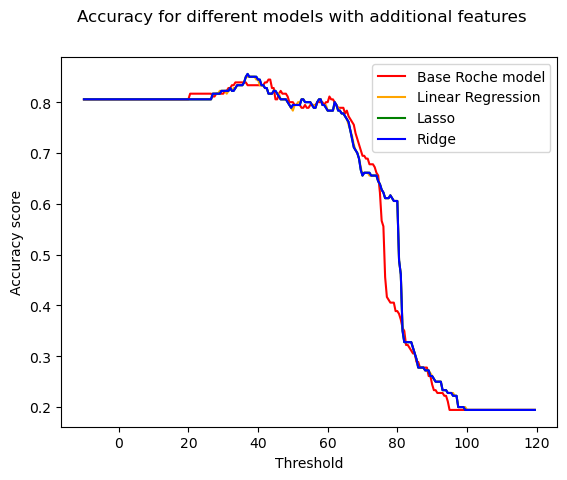

In [104]:
fig = plt.figure()
plt.plot(np.arange(-10,120,0.5),base_accuracy, c='red')
plt.plot(np.arange(-10,120,0.5),linear_new_accuracy, c='orange')
plt.plot(np.arange(-10,120,0.5),lasso_new_accuracy, c='green')
plt.plot(np.arange(-10,120,0.5),ridge_new_accuracy, c='blue')
plt.legend(['Base Roche model','Linear Regression','Lasso','Ridge'])
plt.xlabel('Threshold')
plt.ylabel('Accuracy score')
fig.suptitle('Accuracy for different models with additional features')

0.8212807881773401
0.8172413793103448
0.8177339901477833
0.8175369458128079


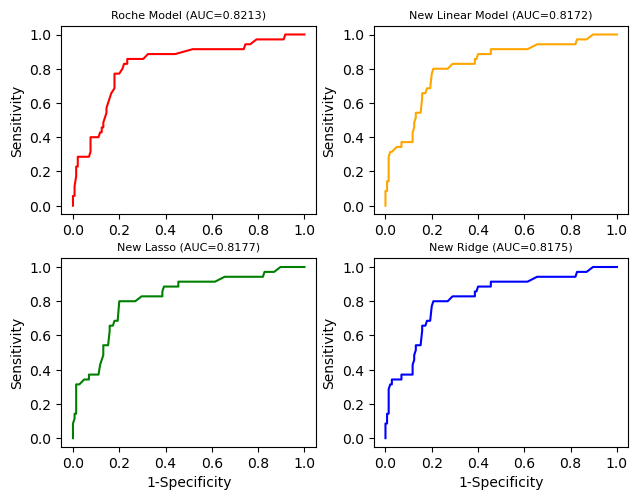

In [105]:
# use subplot to compare ROC curves in the same figure
a1 = [1-x for x in base_specificity]
a2= [1-x for x in linear_new_specificity]
a3= [1-x for x in lasso_new_specificity]
a4= [1-x for x in ridge_new_specificity]

fig, ax = plt.subplots(nrows=2, ncols=2)
fig.tight_layout()
ax[0,0].plot(a1, base_recall, c='red')
ax[0,1].plot(a2, linear_new_recall, c='orange')
ax[1,0].plot(a3, lasso_new_recall, c='green')
ax[1,1].plot(a4, ridge_new_recall, c='blue')

ax[0,0].set(ylabel='Sensitivity')
ax[0,1].set(ylabel='Sensitivity')
ax[1,0].set(xlabel='1-Specificity',ylabel='Sensitivity')
ax[1,1].set(xlabel='1-Specificity',ylabel='Sensitivity')
ax[0,0].set_title('Roche Model (AUC=0.8213)',fontsize=8)
ax[0,1].set_title('New Linear Model (AUC=0.8172)',fontsize=8)
ax[1,0].set_title('New Lasso (AUC=0.8177)',fontsize=8)
ax[1,1].set_title('New Ridge (AUC=0.8175)',fontsize=8)


auc1=0 ; auc2=0; auc3=0; auc4=0;
for k in range(len(a1)-3):
    auc1 += (a1[k+1] - a1[k]) * (base_recall[k+1] + base_recall[k]) / 2
for k in range(len(a1)-3):
    auc2 += (a2[k+1] - a2[k]) * (linear_new_recall[k+1] + linear_new_recall[k]) / 2
for k in range(len(a2)-3):
    auc3 += (a3[k+1] - a3[k]) * (lasso_new_recall[k+1] + lasso_new_recall[k]) / 2
for k in range(len(a2)-3):
    auc4 += (a4[k+1] - a4[k]) * (ridge_new_recall[k+1] + ridge_new_recall[k]) / 2
print(auc1)
print(auc2)
print(auc3)
print(auc4)

### Section 4 conclusions
**1.After including new features, all the 3 models (Linear Regressio, Lasso Regression and Ridge Regression) outperform Roche model in accuracy curve, because they have greater maximum accuracy and the drop of their accuracy is less steep when we raise the threshold**

**2.All the 3 models (Linear Regressio, Lasso Regression and Ridge Regression) have very similar performance and they are almost completely overlapped in the accuracy curve plot**

**3.After including new features, all the 3 models (Linear Regressio, Lasso Regression and Ridge Regression) don't outperform Roche model when they are evaluated using ROC curves**


### Future directions
**1.Explore additional regression models including Random Forest Regressor and Gradient Boosting Regressor may further improve the model performance, since there could be some non-linear relationship between the selected features and the ASO toxicity score**

**2.Explore addtional datasets from published literatures or patents to increase the sample size of training set my further improve the accuracy of the model**

**3. Spend additional efforts in feature engineering (e.g. adding the frequency information of all the 16 types of dinucleotides) may further improve the model accuracy**